<a href="https://colab.research.google.com/github/ETorresSacha/Analisis-de-datos/blob/main/analisis_datos_reto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import io
import os
from google.colab import files
import seaborn as sns
from sklearn import  preprocessing
import random

In [ ]:
# Descargar el archivo
# Guardar en Excel
data.to_excel("data7.xlsx", index=False)
files.download('data7.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ANÁLISIS DE DATOS DEL RUL
### TABLA TELEMETRÍA Y ALERTAS

In [2]:
uploaded = files.upload()

Saving rul_potenciaa.xlsx to rul_potenciaa.xlsx


In [ ]:
# para borrar los datos que se subió
os.remove("CAEX_RUL4.xlsx")

In [251]:
data = pd.read_excel(io.BytesIO(uploaded['rul_potenciaa.xlsx']))

/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [252]:
# vamos a crear los ciclos por cada equipo

# Ordenamos primero por equipo y fecha
data = data.sort_values(by=['equipment','fecha_telemetria'])

# Definimos el inicio de un nuevo ciclo cuando:
# - cambia el equipo
# - o el RUL vuelve a subir (después de llegar a 0)
data["new_cycle"] = (
    (data["equipment"] != data["equipment"].shift()) |   # cambio de equipo
    (data["RUL_Horas"] > data["RUL_Horas"].shift())            # RUL "reinicia"
).astype(int)

# Ahora creamos un contador acumulativo de ciclos dentro de cada equipo
data["Ciclo"] = data.groupby("equipment")["new_cycle"].cumsum()

# Eliminamos la columna auxiliar
data = data.drop(columns=["new_cycle"])

# Mover columna Ciclo a la posición 1
col = data.pop("Ciclo")            # sacar la columna
data.insert(5, "Ciclo", col)       # insertarla en la posición 5

In [253]:
# Eliminamos la columna 'rn',no es importante
data = data.drop(columns=['rn'])

In [254]:
# Seleccionamos solo las variables que son mas relevantes
data = data[['equipment','RUL_Horas','horometro','Ciclo','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']]

#data = data[['equipment','RUL_Horas','horometro','Ciclo','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min',
 #            'Engine_Oil_Filter_Differential_Pressure','DC_Power_Max']]

In [ ]:

# data = data[['equipment','RUL_Horas','horometro','Ciclo','Ambient_Temp_Max','Boost_RB_Press_Max','Exhaust_Temp_Max_LF','Exhaust_Temp_Max_LR','Steering_Press_Max','Ambient_Temp_Ave','Blow_by_Press_Max','Eng_Oil_Temp_Max','Exhaust_Temp_Max_RR',
# 'Ambient_Temp_Min','Engine_Coolant_Temp_Max','Motor_B_Power_Ave','Brake_Oil_Temp_LF_Max','DC_Power_Max','Eng_Oil_Press_Hi_Idle_Min','Hoist_Press2_Max',	'Engine_Oil_Filter_Differential_Pressure','Exhaust_Temp_Max_RF']]

In [255]:
data.head()

,equipment,RUL_Horas,horometro,Ciclo,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min
0,C301,632,38458.7,1,180.0,510,96.0,85,380.0
1,C301,576,38478.7,1,190.0,750,94.0,84,380.0
2,C301,545,38498.7,1,200.0,590,94.0,84,380.0
3,C301,513,38518.7,1,200.0,500,96.0,85,380.0
4,C301,464,38538.7,1,200.0,550,95.0,84,370.0


In [256]:
# Seleccionamos los equipos mas relevantes (3 equipos)
data= data[data["equipment"].isin(["C314","C311","C324"])] # Se seleccionó de acuerdo a un analisis de sus métricas de cada equipo, siendo estos equipos los mejores.

In [257]:
data = data.reset_index(drop=True)
data.head()

,equipment,RUL_Horas,horometro,Ciclo,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min
0,C311,2813,39255.6,1,200.0,690,92.0,84,420.0
1,C311,2785,39275.6,1,210.0,680,91.0,83,420.0
2,C311,2748,39295.6,1,210.0,740,92.0,83,410.0
3,C311,2712,39315.6,1,210.0,720,95.0,83,420.0
4,C311,2673,39335.6,1,200.0,690,96.0,83,410.0


array([[<Axes: title={'center': 'RUL_Horas'}>,
        <Axes: title={'center': 'horometro'}>,
        <Axes: title={'center': 'Ciclo'}>],
       [<Axes: title={'center': 'Eng_Oil_Press_Lo_Idle_Min'}>,
        <Axes: title={'center': 'Eng_Oil_Press_Max'}>,
        <Axes: title={'center': 'Eng_Oil_Temp_Max'}>],
       [<Axes: title={'center': 'Engine_Coolant_Temp_Max'}>,
        <Axes: title={'center': 'Eng_Oil_Press_Hi_Idle_Min'}>, <Axes: >]],
      dtype=object)

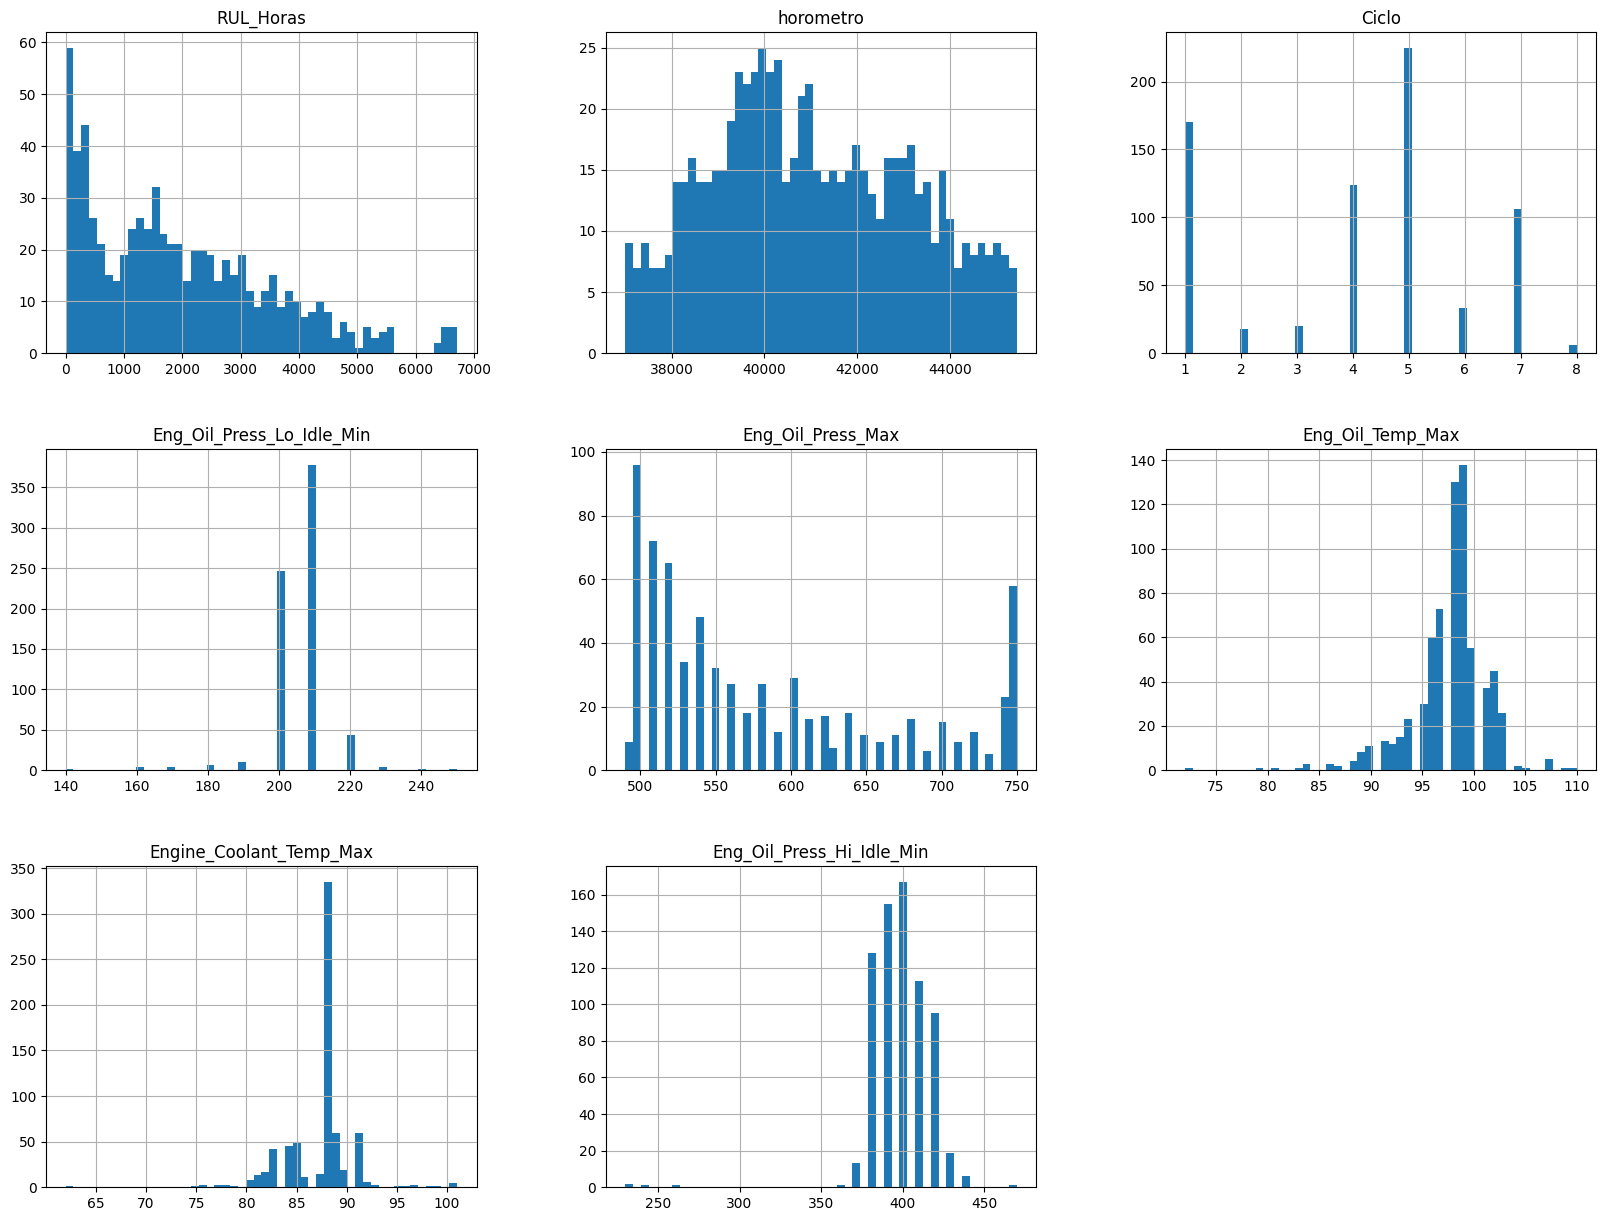

In [258]:
# visualización de los datos en histograms
data.hist(bins=50, figsize=(20,15))

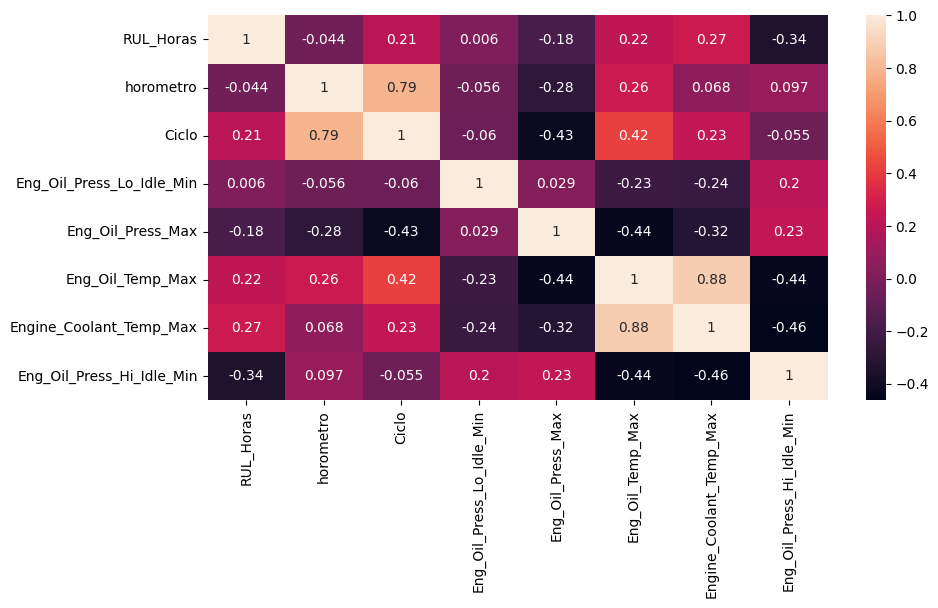

In [261]:
# Correlación
# NOTA: La correlación es referencial, ya que la determinación de las variables se realizó con 'sklearn.ensemble', el cual ayuda a determinar las mejores features;
#       mientras que la correlación solo es ver la linealidad de cada variable respecto a RUL_Horas.

plt.figure(figsize=(10,5))
# Filtrar solo las columnas numéricas
numeric_data = data.select_dtypes(include='number')

# Crear el heatmap
sns.heatmap(numeric_data.corr(), annot=True)
plt.show()

In [262]:
# Calcular la correlación con todas las columnas numéricas
corr = data.corr(numeric_only=True)

# Si quieres la correlación respecto a una variable específica (ej. "RUL_Horas")
correlacion = corr["RUL_Horas"].sort_values(ascending=False)

correlacion


,RUL_Horas
RUL_Horas,1.000000
Engine_Coolant_Temp_Max,0.267818
Eng_Oil_Temp_Max,0.224443
Ciclo,0.206668
Eng_Oil_Press_Lo_Idle_Min,0.005976
horometro,-0.043858
Eng_Oil_Press_Max,-0.178528
Eng_Oil_Press_Hi_Idle_Min,-0.344661


### visualización boxplot

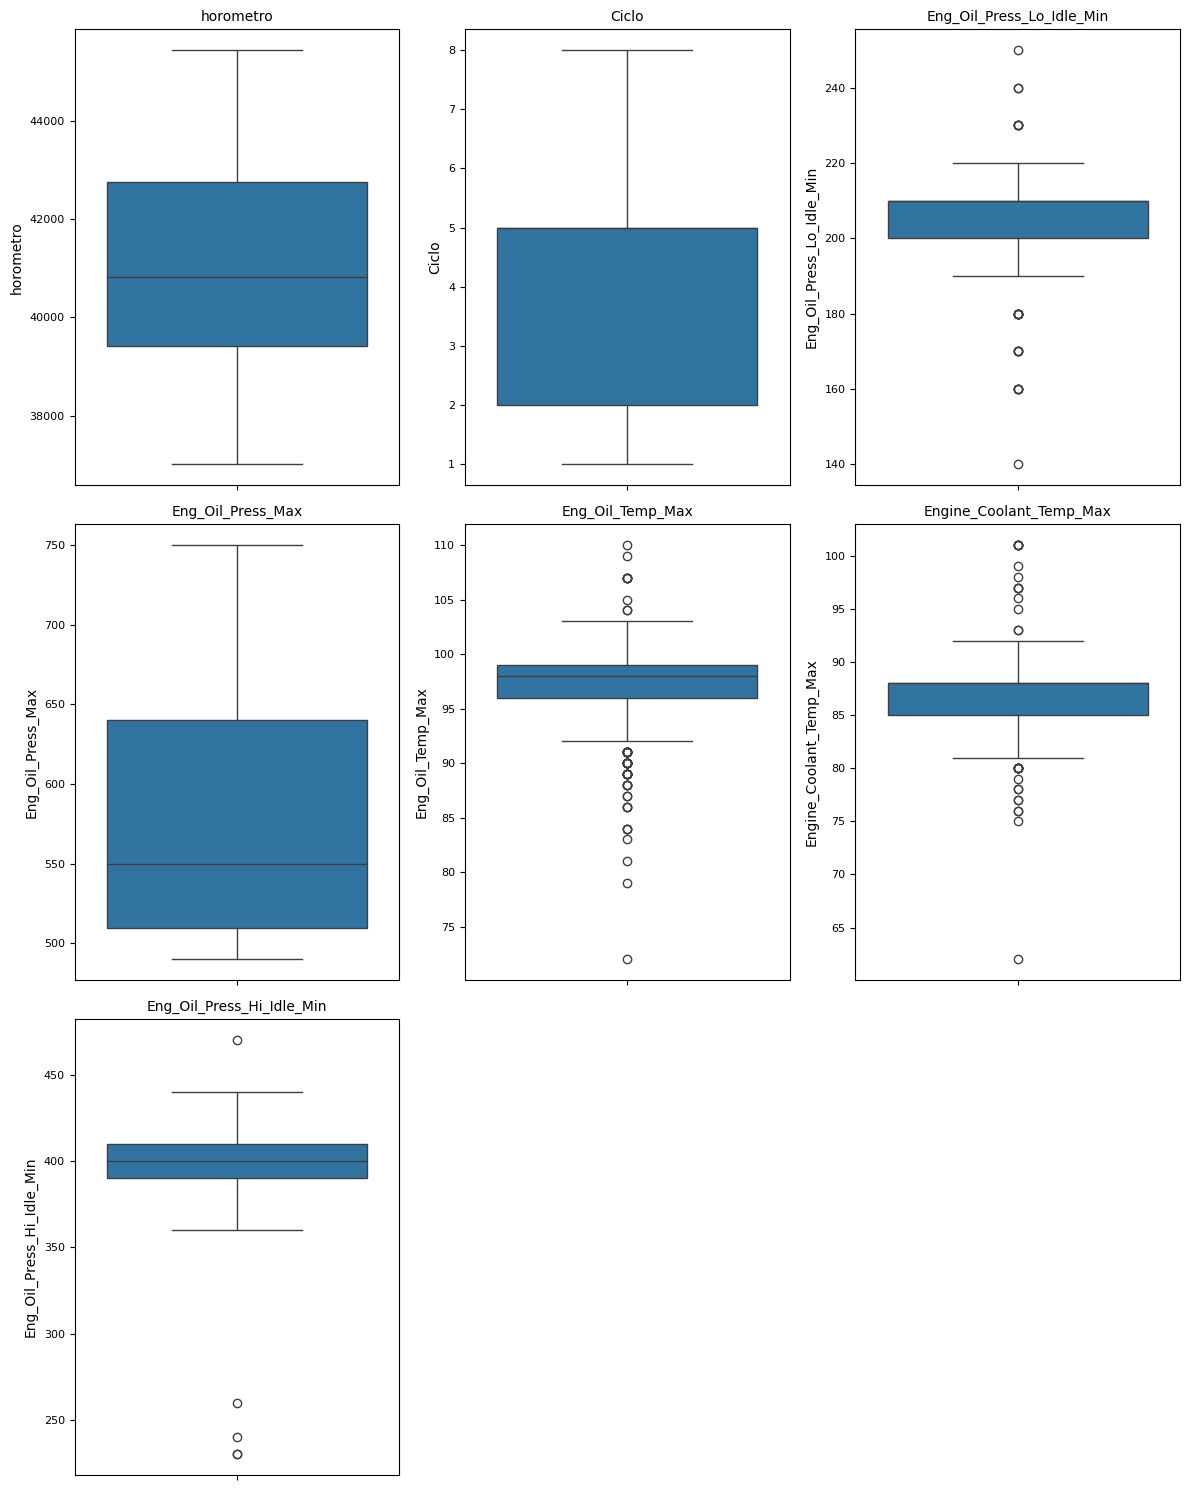

In [263]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Columnas de interés (excluyendo la target RUL_Horas)
cols = ['horometro','Ciclo','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']

#cols = ['horometro','Ciclo','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min',
    #         'Engine_Oil_Filter_Differential_Pressure','DC_Power_Max']
# Definir cantidad de filas (4 gráficos por fila)
n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 5*n_rows))

# Aplanar los ejes (para recorrerlos fácilmente)
axes = axes.flatten()

# Graficar cada variable en su subplot
for i, col in enumerate(cols):
    sns.boxplot(y=data[col], ax=axes[i])
    axes[i].set_title(col, fontsize=10)
    axes[i].tick_params(axis='y', labelsize=8)

# Eliminar los ejes vacíos si sobran
for j in range(len(cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [264]:
# Informacion de los datos
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 702 entries, 0 to 701
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   equipment                  702 non-null    object 
 1   RUL_Horas                  702 non-null    int64  
 2   horometro                  702 non-null    float64
 3   Ciclo                      702 non-null    int64  
 4   Eng_Oil_Press_Lo_Idle_Min  701 non-null    float64
 5   Eng_Oil_Press_Max          702 non-null    int64  
 6   Eng_Oil_Temp_Max           702 non-null    float64
 7   Engine_Coolant_Temp_Max    702 non-null    int64  
 8   Eng_Oil_Press_Hi_Idle_Min  702 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 49.5+ KB


In [265]:
# Completamos los valores faltantes con la mediana
data['Eng_Oil_Press_Lo_Idle_Min'] = data['Eng_Oil_Press_Lo_Idle_Min'].fillna(data['Eng_Oil_Press_Lo_Idle_Min'].median())

In [266]:
# Tratamiento de outliers
# NOTA: Solo de las variables necesarias

# Reemplazar todos los NaN por 0
data = data.fillna(0)
variables_data=['Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']

# variables_data = ['Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min',
#              'Engine_Oil_Filter_Differential_Pressure','DC_Power_Max']
#variables_data =['Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']
#variables_data=['Engine_Oil_Filter_Differential_Pressure','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','DC_Power_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']

for col in variables_data:
  if col in data.select_dtypes(include=[np.number]).columns:  # asegurar que sea numérica
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR

    # Reemplazar outliers por NaN
    data[col] = data[col].mask((data[col] < lower_limit) | (data[col] > upper_limit), np.nan)

# Si quieres luego reemplazar por la mediana:
data = data.fillna(data.median(numeric_only=True))

## Convertimos los datos categoricos a datos numéricos
Los nombres de los equipos

In [267]:
from sklearn.preprocessing import OneHotEncoder
data_equipment = data[['equipment']]
cat_encoder = OneHotEncoder()
data_car_1hot = cat_encoder.fit_transform(data_equipment)

In [268]:
# Visualizar los datos categóricos
encoded_df = pd.DataFrame(data_car_1hot.toarray(), columns=cat_encoder.get_feature_names_out()).astype(int)
encoded_df

,equipment_C311,equipment_C314,equipment_C324
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
697,0,0,1
698,0,0,1
699,0,0,1
700,0,0,1


### Creamos los datos para Machine Learning

In [269]:
# Variables dependientes e independientes
y = data['RUL_Horas']  # y = data['RUL_Horas'].values.reshape(-1,1)
x= data[['horometro','Ciclo','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min']]

# x = data[['horometro','Ciclo','Eng_Oil_Press_Lo_Idle_Min','Eng_Oil_Press_Max','Eng_Oil_Temp_Max','Engine_Coolant_Temp_Max','Eng_Oil_Press_Hi_Idle_Min',
#              'Engine_Oil_Filter_Differential_Pressure','DC_Power_Max']]
x

,horometro,Ciclo,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min
0,39255.6,1,200.0,690,92.0,84.0,420.0
1,39275.6,1,210.0,680,98.0,83.0,420.0
2,39295.6,1,210.0,740,92.0,83.0,410.0
3,39315.6,1,210.0,720,95.0,83.0,420.0
4,39335.6,1,200.0,690,96.0,83.0,410.0
...,...,...,...,...,...,...,...
697,43894.2,5,210.0,520,99.0,88.0,370.0
698,43914.2,5,200.0,520,99.0,88.0,380.0
699,43934.2,5,210.0,740,98.0,88.0,380.0
700,43954.2,5,200.0,510,99.0,89.0,380.0


In [270]:
# concadenamos los valores independientes(valores de los sensores) con las variable categóricas(equipment)

data_concadenado= pd.concat([x,encoded_df],axis=1)  # unimos los datos cateoricos  co los datos independientes
data_concadenado.head()

,horometro,Ciclo,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min,equipment_C311,equipment_C314,equipment_C324
0,39255.6,1,200.0,690,92.0,84.0,420.0,1,0,0
1,39275.6,1,210.0,680,98.0,83.0,420.0,1,0,0
2,39295.6,1,210.0,740,92.0,83.0,410.0,1,0,0
3,39315.6,1,210.0,720,95.0,83.0,420.0,1,0,0
4,39335.6,1,200.0,690,96.0,83.0,410.0,1,0,0


In [271]:
# Tomamos los valores de data_concadenado y los asignamos a "x"

x= data_concadenado  # x= data_concadenado.values
x

,horometro,Ciclo,Eng_Oil_Press_Lo_Idle_Min,Eng_Oil_Press_Max,Eng_Oil_Temp_Max,Engine_Coolant_Temp_Max,Eng_Oil_Press_Hi_Idle_Min,equipment_C311,equipment_C314,equipment_C324
0,39255.6,1,200.0,690,92.0,84.0,420.0,1,0,0
1,39275.6,1,210.0,680,98.0,83.0,420.0,1,0,0
2,39295.6,1,210.0,740,92.0,83.0,410.0,1,0,0
3,39315.6,1,210.0,720,95.0,83.0,420.0,1,0,0
4,39335.6,1,200.0,690,96.0,83.0,410.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
697,43894.2,5,210.0,520,99.0,88.0,370.0,0,0,1
698,43914.2,5,200.0,520,99.0,88.0,380.0,0,0,1
699,43934.2,5,210.0,740,98.0,88.0,380.0,0,0,1
700,43954.2,5,200.0,510,99.0,89.0,380.0,0,0,1


# ENTRENAMIENTO CON MACHINE LEARNING
## Bosques aleatorios

In [283]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

# Entrenar Random Forest

#model = RandomForestRegressor()
model = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)


# Evaluar métricas

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print('\n**** MÉTRICAS ****')
print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")
print('******************')



**** MÉTRICAS ****
MAE: 77.14
MSE: 25335.90
RMSE: 159.17
R²: 0.9883
******************


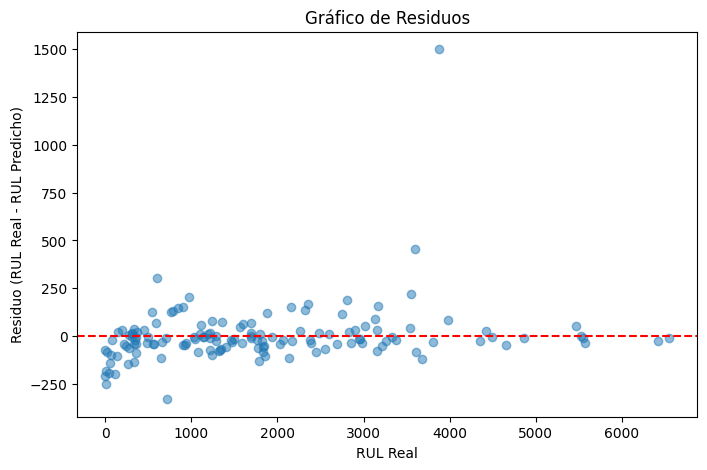

In [284]:
import matplotlib.pyplot as plt
import numpy as np

# Asegurar vectores 1D
y_test = np.ravel(y_test)   # convierte (n,1) -> (n,)
y_pred = np.ravel(y_pred)   # por si acaso

# Calcular residuos
residuos = y_test - y_pred

# Crear gráfico de dispersión
plt.figure(figsize=(8,5))
plt.scatter(y_test, residuos, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')

plt.xlabel("RUL Real")
plt.ylabel("Residuo (RUL Real - RUL Predicho)")
plt.title("Gráfico de Residuos")
plt.show()


Visualización de los resultados y comparativos por equipo

In [285]:
import pandas as pd

# Creamos un DataFrame con equipo, valor real y valor predicho
resultados = pd.DataFrame({
    "Equipo": ((X_test.iloc[:]).iloc[:,-3:]).idxmax(axis=1),   # equipo al que pertenece
    "RUL Real": y_test[:],                       # valores reales
    "RUL Predicción": y_pred[:],                 # valores predichos
    "Diferencia": y_test[:] - y_pred[:]       # error de predicción
})

resultados.sort_values(by="Equipo", ascending=True)


,Equipo,RUL Real,RUL Predicción,Diferencia
192,equipment_C311,2267,2240.19,26.81
204,equipment_C311,1940,1943.53,-3.53
256,equipment_C311,348,365.92,-17.92
31,equipment_C311,1828,1910.47,-82.47
109,equipment_C311,549,422.38,126.62
...,...,...,...,...
548,equipment_C324,568,608.36,-40.36
537,equipment_C324,1147,1153.15,-6.15
598,equipment_C324,4863,4873.19,-10.19
652,equipment_C324,2958,2971.83,-13.83


Gráficos por equipo

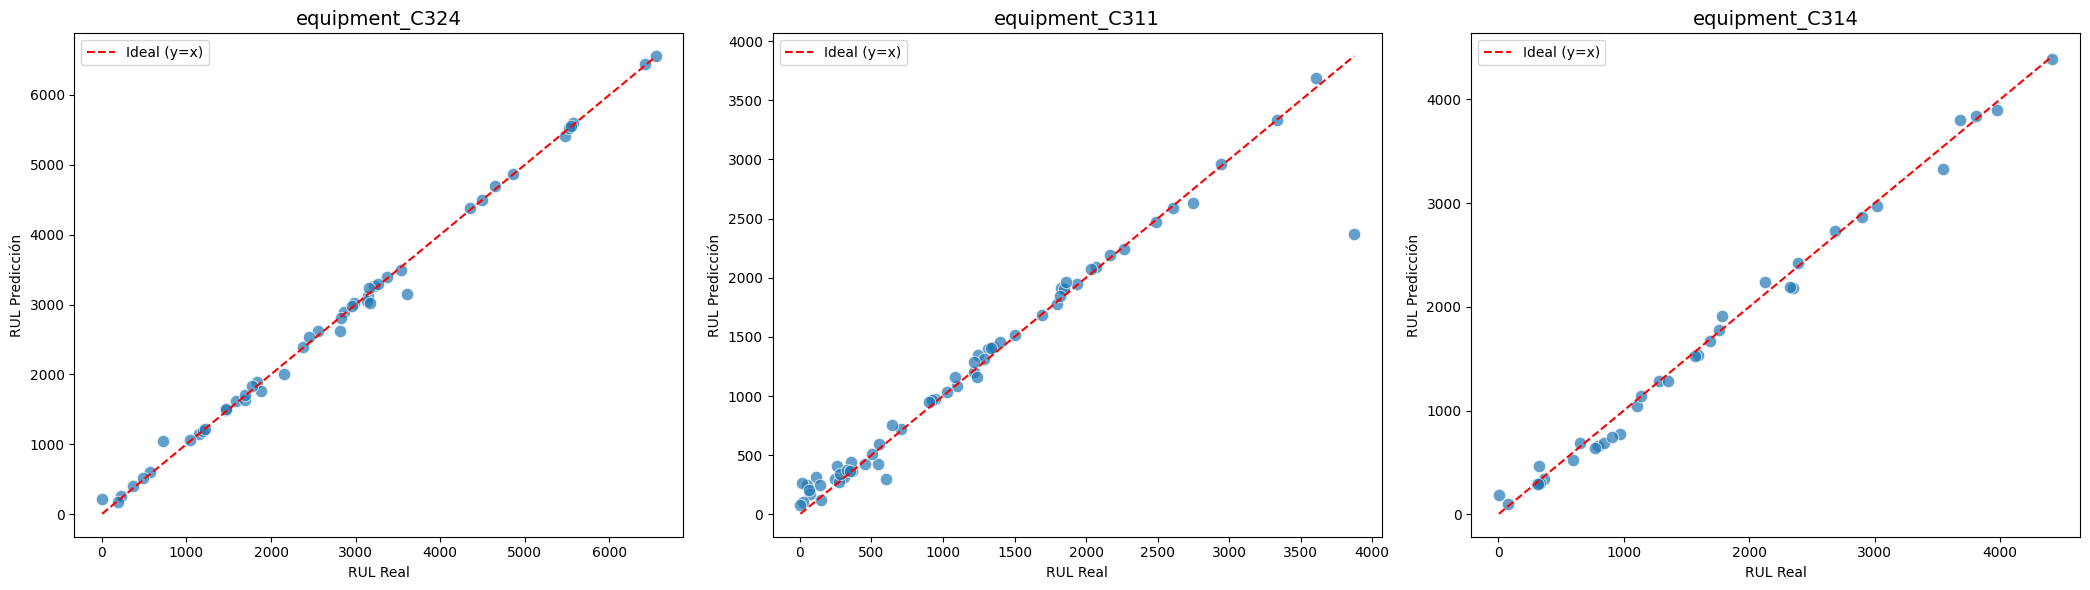


📊 Resultados para equipment_C324:
R² = 0.9962
Media Diferencia = -2.10
Desviación Estándar = 106.38

📊 Resultados para equipment_C311:
R² = 0.9507
Media Diferencia = -10.19
Desviación Estándar = 215.56

📊 Resultados para equipment_C314:
R² = 0.9932
Media Diferencia = 29.42
Desviación Estándar = 97.03


In [286]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# ==== 1. Crear DataFrame con tus datos ====
df = pd.DataFrame(resultados, columns=["Index", "Equipo", "RUL Real", "RUL Predicción", "Diferencia"])

# ==== 2. Gráficos por equipo en horizontal ====
equipos = df["Equipo"].unique()
n = len(equipos)

fig, axes = plt.subplots(1, n, figsize=(7 * n, 6), sharex=False, sharey=False)

if n == 1:  # caso de un solo equipo
    axes = [axes]

metricas = []  # guardamos las métricas para imprimirlas debajo

for i, eq in enumerate(equipos):
    subset = df[df["Equipo"] == eq]

    # Scatterplot
    sns.scatterplot(data=subset, x="RUL Real", y="RUL Predicción", s=80, alpha=0.7, ax=axes[i])
    sns.lineplot(x=subset["RUL Real"], y=subset["RUL Real"], color="red", linestyle="--", ax=axes[i], label="Ideal (y=x)")

    axes[i].set_title(f"{eq}", fontsize=14)
    axes[i].legend()

    # ==== 3. Métricas estadísticas ====
    r2 = r2_score(subset["RUL Real"], subset["RUL Predicción"])
    media = subset["Diferencia"].mean()
    std = subset["Diferencia"].std()

    metricas.append((eq, r2, media, std))

plt.tight_layout()
plt.show()

# ==== 4. Mostrar métricas debajo ====
for eq, r2, media, std in metricas:
    print(f"\n📊 Resultados para {eq}:")
    print(f"R² = {r2:.4f}")
    print(f"Media Diferencia = {media:.2f}")
    print(f"Desviación Estándar = {std:.2f}")



## 🔎**Observación técnica mejorada**

El modelo presenta un sesgo sistemático hacia la sobrepredicción en más de la mitad de los casos analizados. Si bien las diferencias entre RUL Real y RUL Predicción no son extremadamente grandes, sí muestran una tendencia consistente que indica un bias positivo en las estimaciones.

Para mitigar este sesgo, se puede aplicar un ajuste post-modelo basado en la media del error (sesgo medio). Específicamente:

1. **Identificación de errores negativos** <br>
Se seleccionan únicamente los casos donde la diferencia entre RUL Real y RUL Predicción es negativa (es decir, cuando el modelo sobrepredice).

2. **Cálculo del sesgo medio**<br>
Se estima la media de estas diferencias negativas. Este valor representa el exceso promedio con el que el modelo está sobreprediciendo en esos escenarios.

3. **Corrección de predicciones**<br>
A las predicciones correspondientes a esos casos se les puede aplicar un ajuste restando este sesgo medio, lo que debería desplazar las predicciones hacia valores más cercanos al RUL real.

### ⚖️ **Justificación**

Esta técnica no cambia el modelo en sí, sino que actúa como una corrección estadística posterior.

Es particularmente útil cuando el modelo generaliza bien (R² alto) pero mantiene un sesgo direccional.

El ajuste reduce la magnitud de los errores sistemáticos sin afectar demasiado a los casos donde la predicción ya es correcta o subestimada.